In [1]:
# imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import skimage.color
import skimage.filters
import skimage.io
import skimage.feature
import skimage.measure
import skimage.color

from textureTransfer import Construct as transfer_texture
%matplotlib inline
%load_ext memory_profiler

### Utility functions

In [2]:
# Scaling or clipping
scale = lambda x, top=255: (top * (x - np.min(x))) / (np.max(x) - np.min(x))
inrange = lambda x: np.where(x > 255, 255, np.where(x < 0, 0, x))
invert = lambda x: np.max(x) - x
print_range = lambda x: print(np.min(x), np.max(x))

### Image input and pre processing

In [3]:
def apply_filter(im, filt, zero_padding=False):
    
    wdth = filt.shape[0]//2
    
    filt_img = np.zeros(im.shape)
    
    if zero_padding:
        im = np.vstack( (np.zeros( (wdth, im.shape[1]) ), im, np.zeros( (wdth, im.shape[1]) ) ) )
        im = np.hstack( (np.zeros( (im.shape[0], wdth) ), im, np.zeros( (im.shape[0], wdth) ) ) )
    else:
        im = np.vstack(([im[0]]*wdth, im, [im[-1]]*wdth))
        im = np.hstack((np.hstack([im[:,0].reshape(-1,1)]*wdth), im, np.hstack([im[:,-1].reshape(-1,1)]*wdth)))

    for i in range(wdth, im.shape[0]-wdth):
        for j in range(wdth, im.shape[1]-wdth):
            filt_img[i-wdth][j-wdth] = np.sum(im[i-wdth:i+wdth+1, j-wdth:j+wdth+1] * filt)
    
    return np.rint(filt_img)

prewitt =  [np.array([
                [-1, 0, 1],
                [-1, 0, 1],
                [-1, 0, 1]
        ]) , np.array([
                [ 1,  1,  1],
                [ 0,  0,  0],
                [-1, -1, -1]
        ])]


In [4]:
def decouple(img):
    
    img = img.astype('float64')
    
    with np.errstate(divide='ignore', invalid='ignore'):
        intensity_layer = np.nan_to_num(np.true_divide(((img[:, :, 0]**2) + (img[:, :, 1]**2) + (img[:, :, 2]**2)) , (img[:,:,0]+img[:, :, 1]+img[:, :, 2])))
        intensity_layer = np.rint(intensity_layer).astype('uint8')
        
        dx = apply_filter(intensity_layer, prewitt[0])
        dy = apply_filter(intensity_layer, prewitt[1])
        
        gradient = np.nan_to_num(np.arctan(dy/dx))
        
    return intensity_layer,gradient

## Distance function

In [5]:
def distance(sI, sG, tI, tG):

    M, N = tI.shape
    
    Y, X = sI.shape
    wdth_y, wdth_x = Y//2, X//2

    tI = np.vstack(([tI[0]]*wdth_y, tI, [tI[-1]]*(Y-wdth_y)))
    tI = np.hstack((np.hstack([tI[:,0].reshape(-1,1)]*wdth_x), tI, np.hstack([tI[:,-1].reshape(-1,1)]*(X-wdth_x))))

    tG = np.vstack(([tG[0]]*wdth_y, tG, [tG[-1]]*(Y-wdth_y)))
    tG = np.hstack((np.hstack([tG[:,0].reshape(-1,1)]*wdth_x), tG, np.hstack([tG[:,-1].reshape(-1,1)]*(X-wdth_x))))
   
    g_img = np.zeros((M, N))
    l_img = np.zeros((M, N))
   
    for i in range(wdth_y, wdth_y+M):
        for j in range(wdth_x, wdth_x+N):
            try:
                g_img[i-wdth_y ,j-wdth_x] = np.average(np.abs(sG - tG[i-wdth_y:i+Y-wdth_y, j-wdth_x:j+X-wdth_x]))
                l_img[i-wdth_y ,j-wdth_x] = np.average(np.abs(sI - tI[i-wdth_y:i+Y-wdth_y, j-wdth_x:j+X-wdth_x]))
            except Exception:
                print("Source shape: ", sG.shape, "  i, j:", i, j, "   Patch shape:",  tG[i-wdth_y:i+Y-wdth_y, j-wdth_x:j+X-wdth_x].shape)
                raise Exception
            
    return (g_img / np.max(g_img)) + (l_img / np.max(l_img))

In [6]:
def inbuilt_distance(sI, sG, tI, tG, scalefactor=True):

    M, N = tI.shape
    
    Y, X = sI.shape
    wdth_y, wdth_x = Y//2, X//2
    try:
        if wdth_y:
            tI = np.vstack(([tI[0]]*wdth_y, tI))
            tG = np.vstack(([tG[0]]*wdth_y, tG))
        if Y-wdth_y-1:
            tI = np.vstack((tI, [tI[-1]]*(Y-wdth_y-1)))
            tG = np.vstack((tG, [tG[-1]]*(Y-wdth_y-1)))
        
        if wdth_x:
            tI = np.hstack((np.hstack([ tI[:,0].reshape(-1,1)]*wdth_x), tI))
            tG = np.hstack((np.hstack([tG[:,0].reshape(-1,1)]*wdth_x), tG))
        if X-wdth_x-1:
            tI = np.hstack((tI, np.hstack([tI[:,-1].reshape(-1,1)]*(X-wdth_x-1))))
            tG = np.hstack((tG, np.hstack([tG[:,-1].reshape(-1,1)]*(X-wdth_x-1))))
            
    except Exception:
        print("\n", wdth_x, wdth_y, Y-wdth_y-1, X-wdth_x-1)
        raise Exception   

#     lum = cv2.matchTemplate(tI,sI, cv2.TM_CCOEFF_NORMED)
#     grd = cv2.matchTemplate(np.rint(scale(tG)).astype('uint8'), np.rint(scale(sG)).astype('uint8'), cv2.TM_CCOEFF_NORMED)
    lum = cv2.matchTemplate(tI,sI, cv2.TM_CCOEFF)
    grd = cv2.matchTemplate(np.rint(scale(tG)).astype('uint8'), np.rint(scale(sG)).astype('uint8'), cv2.TM_CCOEFF)

    if scalefactor:
        return scale(invert(lum+grd), 1)
    
    return invert(lum+grd)

In [7]:
def median_filter(im, k):
        
    filt_img = np.zeros(im.shape)

    wdth = k//2

    im = np.vstack(([im[0]]*wdth, im, [im[-1]]*(k-wdth)))
    im = np.hstack((np.hstack([im[:,0].reshape(-1,1)]*wdth), im, np.hstack([im[:,-1].reshape(-1,1)]*(k-wdth))))

    for j in range(wdth, im.shape[1]-wdth):
        for i in range(wdth, im.shape[0]-wdth):
            x = np.median(im[i-wdth:i+k-wdth+1, j-wdth:j+k-wdth+1])
            filt_img[i-wdth][j-wdth] = x
    return filt_img

## Age Map function

In [8]:
def age(source_patch, target, K, num_bins=1000):
    
    sI, sG = source_patch
    tI, tG = target
    dist_mat = inbuilt_distance(sI, sG, tI, tG, False)
    
    ## Method 1
    # discrete = np.rint(scale(dist_mat)).astype('uint8')
    # size = sI.shape[0]//2
    # size = max(1, size + (1-(size%2)))
    # discrete = cv2.medianBlur(discrete, size)

    # K_distances = np.sort(np.unique(discrete).flatten())[:K]
    # co_ords = []
    # for i in K_distances:
    #     x, y = np.where(discrete == i)
    #     for j in zip(x, y):
    #         co_ords.append(j)

    # K_neighbours = [dist_mat[x, y] for (x, y) in co_ords]
    # K_neighbours = [dist_mat[x, y] for (x, y) in co_ords]

    # return np.average(K_neighbours)
    
    ## Method 2
    bins = np.digitize(dist_mat, np.linspace(np.min(dist_mat), np.max(dist_mat), num_bins))
    bins_mapped = np.linspace(np.min(dist_mat), np.max(dist_mat), num_bins)[bins-1]
    vals, counts = np.unique(bins_mapped, return_counts=True)
    cumsum = np.cumsum(counts)
    cumsum = cumsum/cumsum[-1]
    x, = np.argwhere(cumsum > K)[0]

    
    K_distances = vals[:x] * counts[:x]
    K_distances = np.sum(K_distances)/np.sum(counts[:x])
    return K_distances



In [9]:
def generate_age_map(I, G, N, K):

    age_map = np.zeros(I.shape, dtype=('float64'))

    for i in range(0, I.shape[0], N):
        for j in range(0, I.shape[1], N):
            x1, x2 = i, min(I.shape[0], i+N)
            y1, y2 = j, min(I.shape[1], j+N)
            age_map[x1:x2, y1:y2] = age( (I[x1:x2, y1:y2], G[x1:x2, y1:y2]) , (I, G), K)

    return age_map


## Colormap

In [10]:
import matplotlib.colors as mcolors


def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

c = mcolors.ColorConverter().to_rgb

heatmap = make_colormap(
    [c('blue'), c('aqua'), 0.33, c('aqua'), c('yellow'), 0.66, c('yellow'), c('red')])

# Testing for age map

In [11]:
# input_texture = cv2.imread('../images/input.png')
# input_texture = cv2.cvtColor(input_texture, cv2.COLOR_BGR2RGB)

# details, gradient = decouple(input_texture)

In [12]:
# %%time
# age_map = generate_age_map(details, gradient, 20, 100/np.product(details.shape))

In [13]:
# plt.figure(figsize=(15, 15))
# plt.subplot(121)
# plt.imshow(cv2.GaussianBlur(age_map,(41, 41),0), cmap=heatmap, alpha=1)
# plt.imshow(input_texture, alpha = 0.5)
# plt.subplot(122)
# plt.imshow(input_texture)
# plt.show()

In [14]:
# inp2 = cv2.imread('../images/texture3.jpeg')
# inp2 = cv2.cvtColor(inp2, cv2.COLOR_BGR2RGB)

# details2, gradient2 = decouple(inp2)

In [15]:
# %%time
# age_map2 = generate_age_map(details2, gradient2, 20, 100/np.product(details2.shape))

In [16]:
# plt.figure(figsize=(15, 15))
# plt.subplot(121)
# plt.imshow(cv2.GaussianBlur(age_map2,(41, 41),0), cmap=heatmap, alpha=1)
# plt.imshow(inp2, alpha = 0.7)
# plt.subplot(122)
# plt.imshow(inp2)
# plt.show()

# Intact texture generation

## Tile detection

### Testing

In [17]:
# input_texture = cv2.imread('../images/texture8.png')
# input_texture = cv2.cvtColor(input_texture, cv2.COLOR_BGR2RGB)

# details, gradient = decouple(input_texture)

In [18]:
# a,b,c=input_texture.shape

# N = a//4

# source_patch_one = input_texture[a//4:a//4+N,b//4:b//4+N, :]
# source_patch_l = details[a//4:a//4+N,b//4:b//4+N]
# source_patch_g = gradient[a//4:a//4+N,b//4:b//4+N]


In [19]:
# a//4, b//4

In [20]:
# %%time
# dist_map = inbuilt_distance(source_patch_l, source_patch_g, details, gradient)

In [21]:
# plt.figure(figsize=(10,10))
# plt.imshow(dist_map ,cmap='gray')
# # plt.axis('off')
# plt.show()

In [22]:
# def local_minimas(dist_map,N):
    
#     a,b=dist_map.shape
#     minima=np.zeros((a,b),dtype='uint8')
#     for i in range(0,a,N):
#         for j in range(0,b,N):
#             X=min(i+N,a)
#             Y=min(j+N,b)
#             patch=dist_map[i:X,j:Y]
#             thresh=np.unique(patch)[np.rint(0.005*(X-i)*(Y-j)).astype('uint8')]
# #             plt.figure(figsize=(10,10))
# #             plt.imshow(patch<thresh,cmap='gray')
# #             plt.axis('off')
#             minima[i:X,j:Y]=patch<thresh     
                      
#     return minima.astype('uint8')                  
                      
                      
                      
                     


In [23]:
def global_minimas(dist_map):
    
    a,b=dist_map.shape
    minima=np.zeros((a,b),dtype='uint8')
    
    thresh=np.unique(dist_map)[np.rint(0.005*(a-1)*(b-1)).astype('uint8')]
    minima=dist_map<thresh     
                      
    return minima.astype('uint8')                  
                      

In [24]:
# global_mask=global_minimas(dist_map)

In [25]:
# g1=global_minimas(dist_map)

In [26]:
# plt.figure(figsize=(20,20))

# plt.subplot(121)
# plt.imshow(input_texture)
# plt.axis('off')

# plt.subplot(122)
# plt.imshow(g1,cmap='gray')
# plt.axis('off')

# plt.show()

In [27]:
# g1_bin= cv2.threshold(g1, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# ret1, labels1 = cv2.connectedComponents(g1_bin)

In [28]:
def make_tile(luminance, gradient,labels):
    a,b=luminance.shape
    N1=a//4
    N2=b//4
    check=np.unique(labels)[1:]
    tiles={}
    global_min={}
    
    for i in check:
        temp=np.where(labels==i)
        l=len(temp[0])
        x=temp[0][l//2]
        y=temp[1][l//2]
        grad_tile=gradient[ max(0,x-N1//2):min(x+N1//2,a-1) , max(0,y-N2//2):min(b-1,y+N2//2) ]
        lum_tile=luminance[ max(0,x-N1//2):min(x+N1//2,a-1) , max(0,y-N2//2):min(b-1,y+N2//2) ]
        
#         print(lum_tile.shape,' ' , grad_tile.shape, ' ', a,b)
#         print(max(0,x-N//2),":",min(x+N//2,a-1) ,"      ", max(0,y-N//2),":",min(b-1,y+N//2))

        tiles[i]=inbuilt_distance(lum_tile, grad_tile, luminance, gradient)
        global_min[i]=global_minimas(tiles[i])
        
    return global_min

In [29]:
# %%time
# pot_tiles1=make_tile(details,gradient,labels1)

In [30]:
def sum_tiles(pot_tiles):
    a,b=pot_tiles[1].shape
    sum_tiles=np.zeros((a,b),dtype='uint8')
    for i in pot_tiles:
        sum_tiles+=pot_tiles[i]
    return sum_tiles    

In [31]:
# sum_tiles1=sum_tiles(pot_tiles1)

In [32]:
def detect_peaks_local(sum_tiles):
    a,b= sum_tiles.shape
    N1=(a)//4
    N2=b//4
    maxima = np.zeros((a,b),dtype='uint8')
    for i in range(0,a,N1):
        for j in range(0,b,N2):
            X=min(i+N1,a)
            Y=min(j+N2,b)
            patch=sum_tiles[i:X,j:Y]
            thresh = np.max(patch)

            if thresh > 0:
                maxima[i:X,j:Y] = patch == thresh
                maxima[maxima == 1] = 255
            else:
                maxima[i:X,j:Y] = patch
#     print('a//3:',a//3,'b//3',b//3)            
    return N1,N2,maxima.astype('uint8')                  

In [33]:
# N1,N2,final_tile_centers1 = detect_peaks_local(sum_tiles1)

# # print(sum_tiles[sum_tiles!=0])
# # print(np.nonzero(final_tile_centers1))
# # print(len(final_tile_centers))
# final_tile_centers1[final_tile_centers1!=0] = 255
# fig,ax = plt.subplots(2,figsize=(10,10))
# ax[0].axis('off')
# ax[1].axis('off')
# ax[0].imshow(sum_tiles1 , cmap = 'gray')
# ax[1].imshow(final_tile_centers1, cmap= 'gray')
# plt.show()

In [34]:
## Finding the Offset Vectors
def grid_calc(final_tile_centers, N1, N2):
    Tile_centers = []
    x,y = np.nonzero(final_tile_centers)[0],np.nonzero(final_tile_centers)[1]

    for c in range(x.shape[0]):
        Tile_centers.append([x[c] , y[c]])
    Tile_centers = np.array(Tile_centers)
    Offset_Vectors = []
    for i in range(Tile_centers.shape[0]):
        for j in range(i+1,Tile_centers.shape[0]):
                Offset_Vectors.append(Tile_centers[i]- Tile_centers[j])
    # Offset_Vectors = np.array(Offset_Vectors)
    u,c = np.unique(Offset_Vectors,axis = 0, return_counts=True)
    sorted_arr = u[c.argsort()]
#     print(sorted_arr[-50:])
        
    v=abs(sorted_arr)
    ## Might need to change bounds here [N1/2, N2/2]
    v=v[ np.where( np.any([np.all(v >= [N1/2, N2/2], axis=1), np.logical_and(v[:, 0] == 0, v[:, 1] >= N2/2), np.logical_and(v[:, 0] >= N1/2, v[:, 1] == 0)], axis=0 ) ) ][-15:]
#     return v
    try:
        x, _ = v[np.argwhere(v[:, 1] == 0)][-1][0]
    except:
        x, _ = v[np.argwhere(v[:, 0] > 0)][-1][0]
    try:
        _, y = v[np.argwhere(v[:, 0] == 0)][-1][0]
    except:
        _, y = v[np.argwhere(v[:, 1] > 0)][-1][0]

    return x, y

In [35]:
# x1,y1=grid_calc(final_tile_centers1, N1, N2)

In [36]:
# x1, y1

In [37]:
# c=0
# for i in range(x1):
#     c+=1
#     if c>2:break
#     d=0   
#     for j in range(y1):
#         d+=1
#         if d>2:break       
#         plt.imshow(input_texture[i*x1:(i+1)*x1,j*y1:(j+1)*y1])
#         plt.show()
#         print('[',i*x1,':',(i+1)*x1,' , ',j*y1,':',(j+1)*y1,']')
        

## Median Image

In [38]:
def median_image(input_texture,x1,y1): 
    tiles = []

    for i in range(x1):
        for j in range(y1):
            xi = i*x1
            xf = (i+1) * x1
            yi = j*y1
            yf = (j+1) * y1

            if (xf < input_texture.shape[0]) and (yf < input_texture.shape[1]):
                tiles.append(input_texture[xi:xf, yi:yf])

    medianTile = np.rint(np.median(tiles, axis=(0)))
    medianImage = np.copy(input_texture)

    for i in range(x1):
        xi = i*x1
        xf = (i+1) * x1
        if xi >= medianImage.shape[0]:
            break
        for j in range(y1):
            yi = j*y1
            yf = (j+1) * y1

            if yi >= medianImage.shape[1]:
                break

            if (xf < medianImage.shape[0]) and (yf < medianImage.shape[1]):
                medianImage[xi:xf, yi:yf] = medianTile
            else:
                xf2 = min(xf, medianImage.shape[0])
                yf2 = min(yf, medianImage.shape[1])
                medianImage[xi:xf2, yi:yf2] = medianTile[:(xf2-xi), :(yf2-yi)]
                
    return medianImage            

In [39]:
                
# med_img=median_image(input_texture,x1,y1)   

In [40]:
# plt.figure(figsize=(20,10))
# plt.subplot(121)
# plt.imshow(input_texture)
# plt.title("Input Image")
# plt.subplot(122)
# plt.imshow(med_img)
# plt.title("Median Image")
# plt.show()

### Final Intact Texture generation

In [41]:
def intact_texture(img_name):
    path='../images/'
    
    img=cv2.imread(path+img_name)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    a,b,c=img.shape
    N = a//4

    details, gradient = decouple(img)
    source_patch_one = img[a//4:a//4+N,b//4:b//4+N, :]
    source_patch_l = details[a//4:a//4+N,b//4:b//4+N]
    source_patch_g = gradient[a//4:a//4+N,b//4:b//4+N]

    dist_map = inbuilt_distance(source_patch_l, source_patch_g, details, gradient)
    
    g=global_minimas(dist_map)
    g_bin= cv2.threshold(g, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    ret, labels = cv2.connectedComponents(g_bin)
    
    pot_tiles=make_tile(details,gradient,labels)
    sum_=sum_tiles(pot_tiles)   
    
    N1,N2,final_tile_centers = detect_peaks_local(sum_)
    x,y=grid_calc(final_tile_centers, N1, N2)
    print(x, y)
    med_img=median_image(img,x,y)
    
    plt.figure(figsize=(20,20))
    plt.subplot(121)
    plt.imshow(img)
    plt.title("Input Image")
    plt.subplot(122)
    plt.imshow(med_img)
    plt.title("Median Image")
    plt.show()
    
    print(N1, N2)

    return med_img, min(N1, N2)

78 77


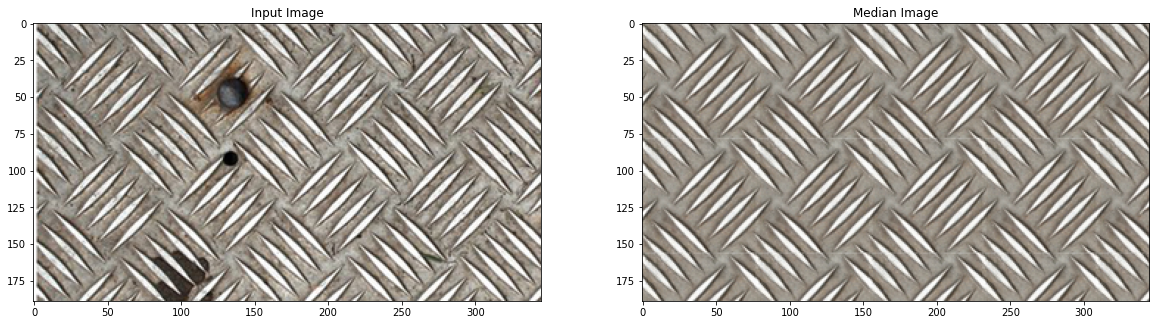

47 86
peak memory: 165.25 MiB, increment: 23.07 MiB
CPU times: user 1.26 s, sys: 60.1 ms, total: 1.32 s
Wall time: 2.31 s


In [42]:
%%time
%%memit
temp0, b0=intact_texture('1.png')

27 27


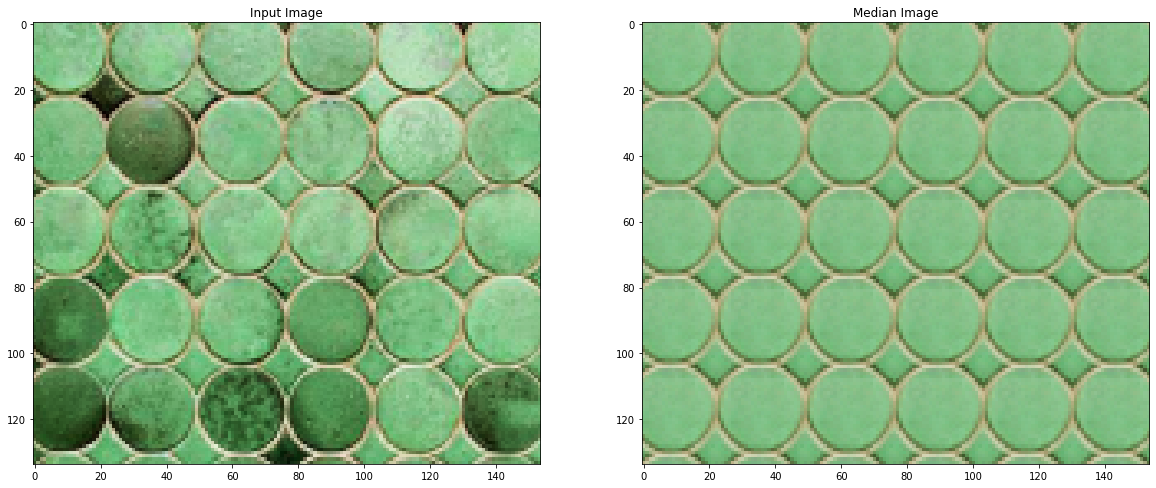

33 38
peak memory: 207.36 MiB, increment: 0.00 MiB
CPU times: user 502 ms, sys: 20.5 ms, total: 523 ms
Wall time: 613 ms


In [94]:
%%time
%%memit
temp1, b1=intact_texture('texture2.png')

81 81


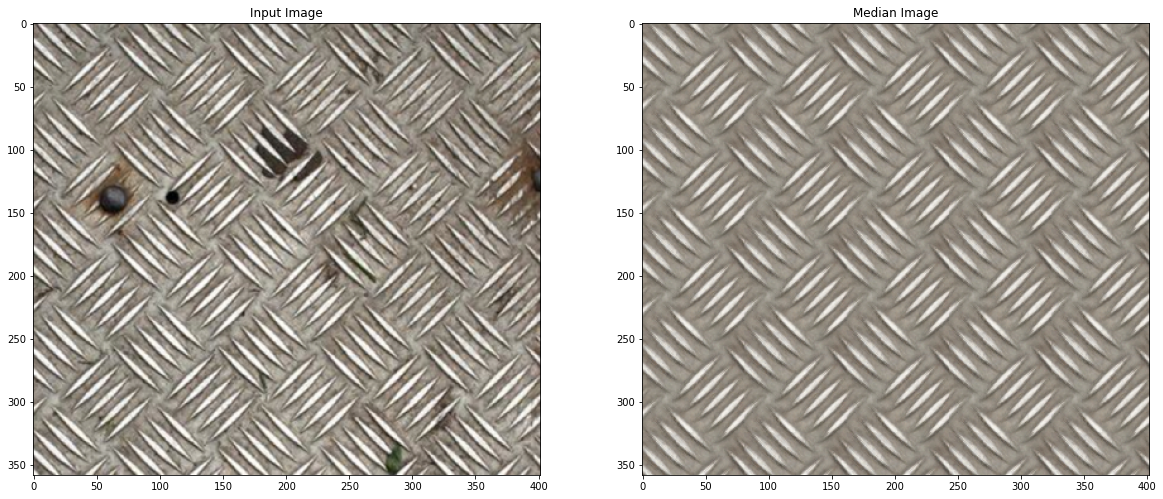

89 100
peak memory: 182.70 MiB, increment: 16.39 MiB
CPU times: user 2.4 s, sys: 31.3 ms, total: 2.43 s
Wall time: 2.48 s


In [44]:
%%time
%%memit
temp2, b2=intact_texture('input.png')

44 45


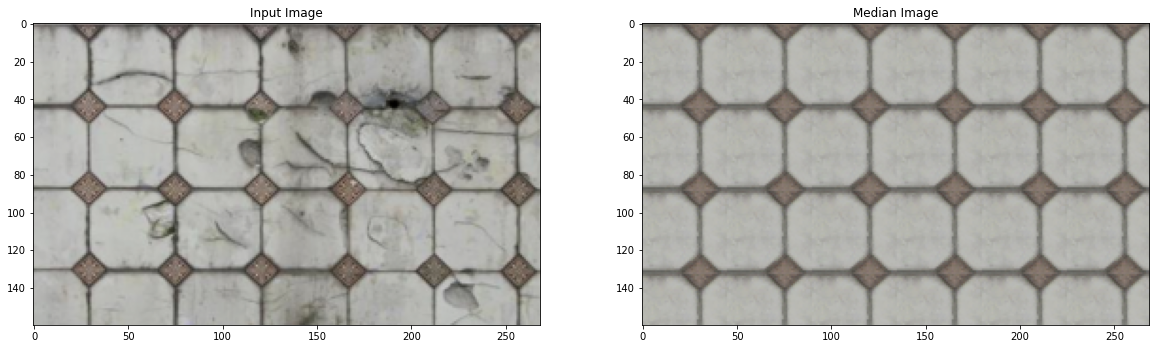

40 67
peak memory: 168.98 MiB, increment: 2.02 MiB
CPU times: user 912 ms, sys: 6.82 ms, total: 919 ms
Wall time: 1.03 s


In [45]:
%%time
%%memit
temp3, b3=intact_texture('texture8.png')

67 83


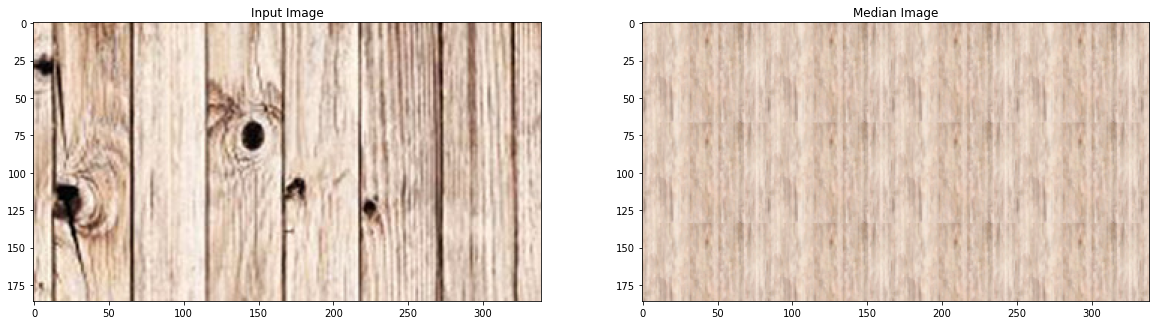

46 84
peak memory: 207.60 MiB, increment: 0.00 MiB
CPU times: user 1.06 s, sys: 28.9 ms, total: 1.09 s
Wall time: 1.18 s


In [91]:
%%time
%%memit
temp4, b4=intact_texture('texture5.jpeg')    

### Texture transfer (Quilting)

In [78]:
import importlib
import textureTransfer
importlib.reload(textureTransfer)
transfer_texture = textureTransfer.Construct

In [79]:
def transfer(input_texture, intact_texture, blocksize):
    img0 = cv2.imread('../images/'+input_texture)
    img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
 
    t = transfer_texture(img0, intact_texture, [blocksize[0], blocksize[1]], 2, alpha=0.1, tolerance=0.001)    
    
    return img0, intact_texture, t.astype('uint8')

In [80]:
%%time
%%memit
img0, intact0, t0 = transfer('1.png', temp0, (77, 77))

peak memory: 716.68 MiB, increment: 509.16 MiB
CPU times: user 1.62 s, sys: 55.4 ms, total: 1.68 s
Wall time: 1.78 s


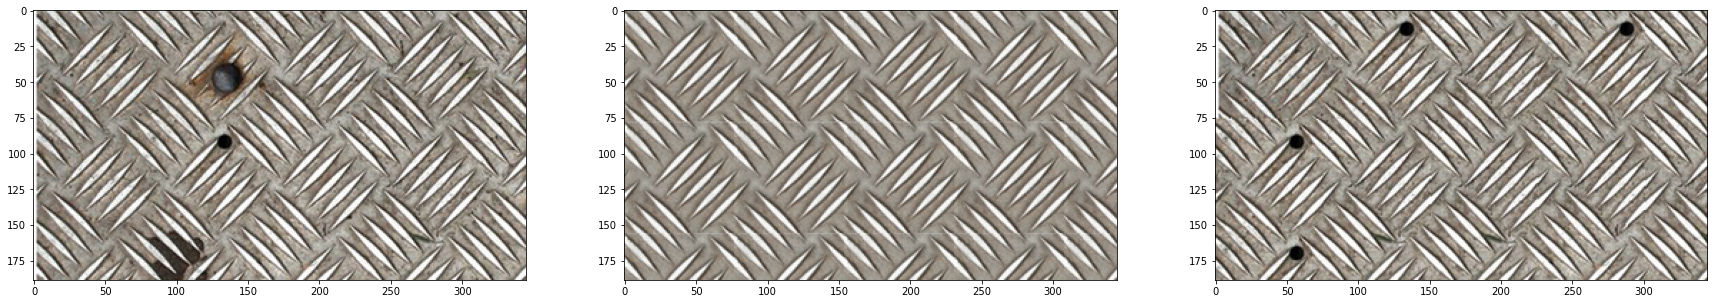

In [81]:
plt.figure(figsize=(30, 10))
plt.subplot(131).imshow(img0)
plt.subplot(132).imshow(intact0)
plt.subplot(133).imshow(t0)
plt.show()

In [95]:
%%time
%%memit
img1, intact1, t1 = transfer('texture2.png', temp1, (27, 27))

peak memory: 235.70 MiB, increment: 28.34 MiB
CPU times: user 598 ms, sys: 11.9 ms, total: 610 ms
Wall time: 715 ms


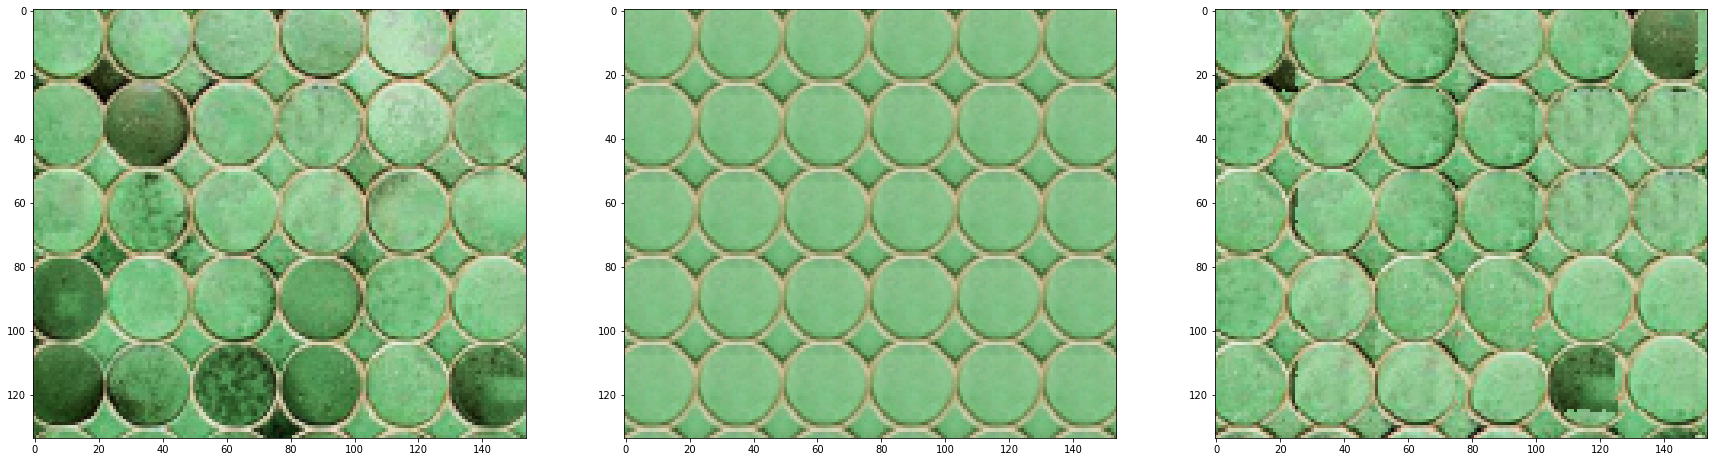

In [96]:
plt.figure(figsize=(30, 10))
plt.subplot(131).imshow(img1)
plt.subplot(132).imshow(intact1)
plt.subplot(133).imshow(t1)
plt.show()

In [84]:
%%time
%%memit
img2, intact2, t2 = transfer('input.png', temp2, (44, 44))

peak memory: 830.30 MiB, increment: 622.73 MiB
CPU times: user 4.9 s, sys: 110 ms, total: 5.01 s
Wall time: 5.12 s


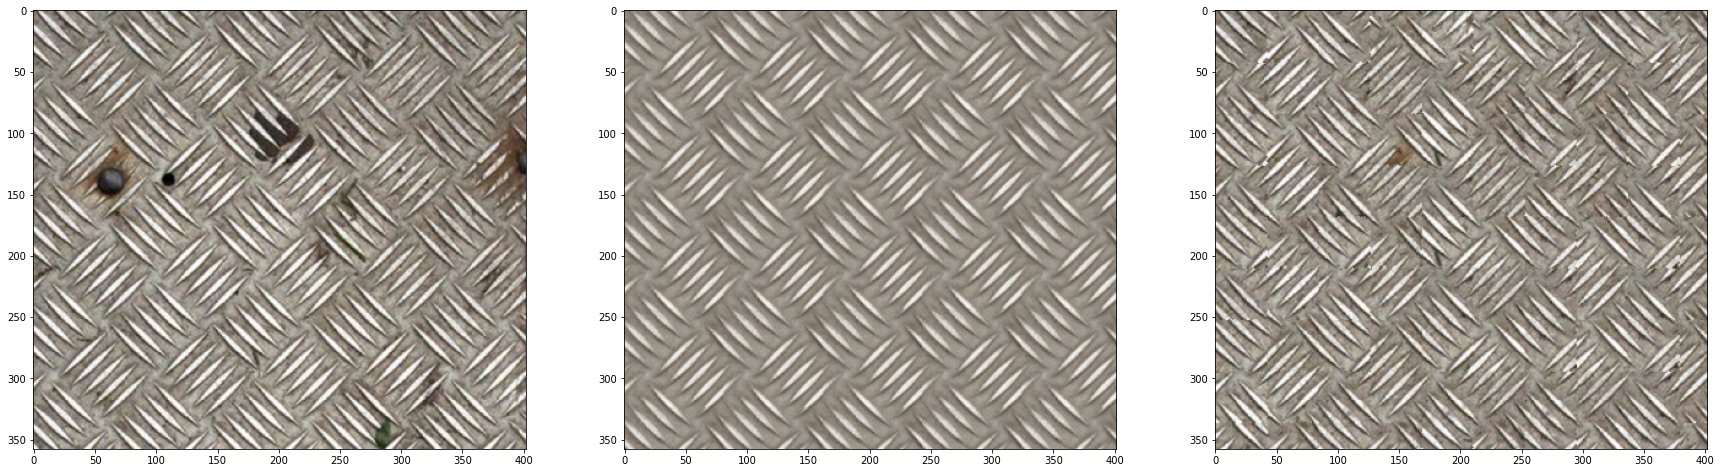

In [85]:
plt.figure(figsize=(30, 10))
plt.subplot(131).imshow(img2)
plt.subplot(132).imshow(intact2)
plt.subplot(133).imshow(t2)
plt.show()

In [86]:
%%time
%%memit
img3, intact3, t3 = transfer('texture8.png', temp3, (44, 44))

peak memory: 352.16 MiB, increment: 144.57 MiB
CPU times: user 1.15 s, sys: 43.7 ms, total: 1.19 s
Wall time: 1.3 s


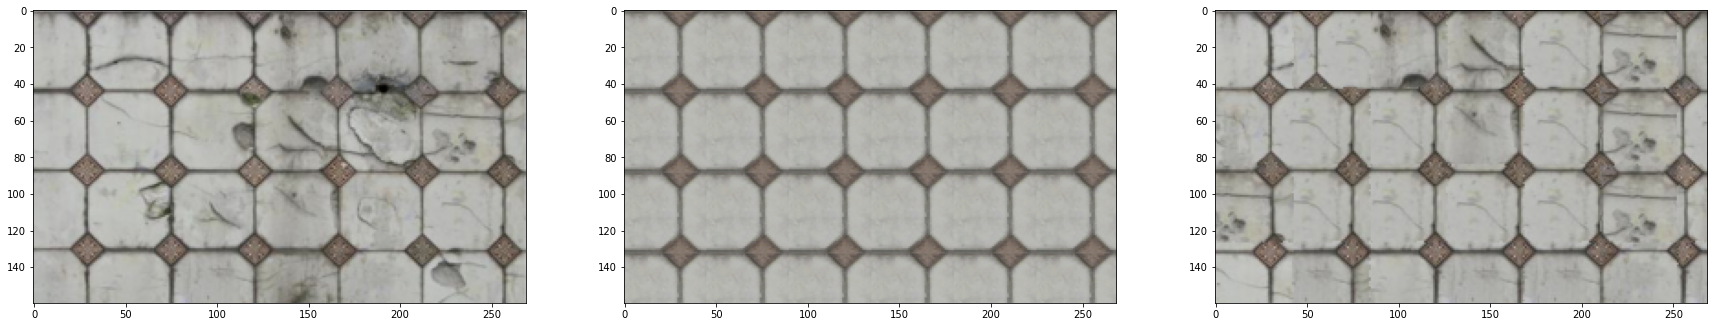

In [87]:
plt.figure(figsize=(30, 10))
plt.subplot(131).imshow(img3)
plt.subplot(132).imshow(intact3)
plt.subplot(133).imshow(t3)
plt.show()